# 5. Регрессионное моделирование
В данном пункте предоставлена реализация предсказаний количественного признака - калий, используя линейную регрессию.

*Задачи*:

1. Выявить самый значимый признак для предсказания таргета
2. Выбрать факторы для обучения модели предсказания этого признака
3. Обучить модель линейной регрессии
4. Проверить качество модели
5. Улучшить модель
6. Сделать вывод

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/processed_data.csv', encoding='cp1251')
data.head()

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,толщина_паренхимы_почек,аик,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез
0,нет,Стадия C1-C2,67,1,1,1,1,1,0,0,...,14.0,0,1,150.0,0.0,0.0,200.0,830.0,1200.0,900.0
1,есть,Стадия C1-C2,69,1,1,0,1,0,0,0,...,15.0,1,4,235.0,143.0,48.0,600.0,640.0,900.0,800.0
2,нет,Пациенты без ХБП,50,1,1,0,1,1,0,0,...,17.0,0,1,210.0,0.0,0.0,250.0,0.0,1800.0,500.0
3,нет,Стадия C1-C2,62,1,1,0,1,1,1,0,...,16.0,1,3,210.0,71.0,43.0,500.0,1283.0,1700.0,1700.0
4,есть,Стадия C1-C2,55,1,1,1,1,1,0,0,...,15.0,1,3,265.0,116.0,74.0,500.0,1560.0,1800.0,1300.0


Исходя из ТЗ составим список признаков, которые важны для предсказания таргета - острого поражения почек

In [3]:
target_features = [
    'развитие_опп',
    'возраст',
    'сахарный_диабет',
    'гб',
    'хбп',
    'сад',
    'дад',
    'чсс',
    'рн',
    'фракция_изгнания',
    'холестерин',
    'креатинин_крови',
    'мочевина',
    'скф_расч',
    'калий',
    'имт',
    'толщина_паренхимы_почек'
]

####Закодируем категориальные признаки в числовые
Хроническая болезнь почек

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['хбп'] = encoder.fit_transform(data['хбп'])

data['хбп'].value_counts()

1    88
0    84
2    14
Name: хбп, dtype: int64

Острое поражение почек

In [5]:
data['развитие_опп'] = data['развитие_опп'].apply(lambda x: 1 if x == 'есть' else 0)
data['развитие_опп'].value_counts()

1    118
0     68
Name: развитие_опп, dtype: int64

## Выявляем самый значимый фактор для предсказания целевой переменной - ОПП

Посмотрим на сформированную выборку параметров, важных для предсказания ОПП

In [6]:
sample = data[target_features]
sample.head()

,развитие_опп,возраст,сахарный_диабет,гб,хбп,сад,дад,чсс,рн,фракция_изгнания,холестерин,креатинин_крови,мочевина,скф_расч,калий,имт,толщина_паренхимы_почек
0,0,67,1,1,1,130.0,80.0,61.0,7.42,68.0,2.47,94.0,8.2,86.0,4.51,30.0,14.0
1,1,69,0,1,1,140.0,90.0,66.0,7.49,54.0,5.73,119.0,6.2,63.0,4.92,29.0,15.0
2,0,50,0,1,0,130.0,90.0,67.0,7.37,60.0,6.22,95.0,5.5,105.0,4.50,30.0,17.0
3,0,62,0,1,1,120.0,80.0,67.0,7.44,57.0,4.22,113.0,5.9,68.0,4.68,30.0,16.0
4,1,55,1,1,1,130.0,80.0,81.0,7.41,67.0,3.52,117.0,5.3,95.0,4.48,33.0,15.0


Разделяем таргет от остальных фичей

In [7]:
y = sample['развитие_опп']
X = sample.drop(columns=['развитие_опп'])

Чтобы оценить и отобрать K наиболее значимых для таргета признаков, тем самым исключив менее важные, используем метод SelectKBest из библиотеки sklearn.

В качестве оценочной функции для этого метода возьмем - f_classif, поскольку целевая переменная - бинарный признак с двумя категориями (есть/нет).

Значение k принимаем за 1, поскольку наша задача - отобрать самый важный признак

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=1)
selector.fit(X, y)
selected_feature = selector.get_feature_names_out()

selected_feature

array(['калий'], dtype=object)

Посмотрим на корелляцию таргета с остальными признаками

In [9]:
sample.corr()

,развитие_опп,возраст,сахарный_диабет,гб,хбп,сад,дад,чсс,рн,фракция_изгнания,холестерин,креатинин_крови,мочевина,скф_расч,калий,имт,толщина_паренхимы_почек
развитие_опп,1.000000,0.010709,0.085634,-0.097444,0.079293,-0.072939,-0.023495,-0.113312,0.132377,-0.117033,0.041518,-0.138270,-0.024574,-0.014830,-0.161594,0.008926,-0.046524
возраст,0.010709,1.000000,0.121061,-0.117252,0.211672,-0.004459,-0.047966,-0.080713,0.068495,0.024595,0.024698,0.153651,0.172237,-0.505358,-0.002204,-0.172149,-0.149527
сахарный_диабет,0.085634,0.121061,1.000000,0.027730,0.041027,0.076149,0.048713,0.058668,-0.053791,-0.033042,-0.098615,-0.046365,0.039291,0.052813,0.220482,0.143318,0.058100
гб,-0.097444,-0.117252,0.027730,1.000000,-0.051981,0.186336,0.327631,0.058588,-0.058061,-0.058194,-0.018528,0.143379,0.081217,0.020685,0.014556,0.112881,0.008345
хбп,0.079293,0.211672,0.041027,-0.051981,1.000000,0.084111,-0.002382,-0.067568,0.113929,-0.045358,0.123059,0.036103,0.324757,-0.233090,0.133628,-0.248328,-0.327746
сад,-0.072939,-0.004459,0.076149,0.186336,0.084111,1.000000,0.477093,-0.095734,-0.025104,-0.039892,0.141192,0.102827,0.254451,-0.016289,0.029823,0.030183,-0.139457
дад,-0.023495,-0.047966,0.048713,0.327631,-0.002382,0.477093,1.000000,0.059528,-0.052828,-0.064179,0.235027,0.050419,0.090026,-0.061299,0.081062,0.039114,-0.027669
чсс,-0.113312,-0.080713,0.058668,0.058588,-0.067568,-0.095734,0.059528,1.000000,0.026134,-0.055745,-0.014750,-0.110289,-0.134130,0.100211,0.069692,0.110860,0.087680
рн,0.132377,0.068495,-0.053791,-0.058061,0.113929,-0.025104,-0.052828,0.026134,1.000000,0.060155,0.016764,0.035380,-0.050085,-0.268804,-0.210630,-0.229556,-0.129592
фракция_изгнания,-0.117033,0.024595,-0.033042,-0.058194,-0.045358,-0.039892,-0.064179,-0.055745,0.060155,1.000000,-0.069549,-0.043004,-0.165238,-0.041970,0.083477,-0.120257,-0.043901


Было обнаружено, что коэффициент корелляции таргета с калием по модулю оказался максимальным значением среди остальных (-0.16). Несмотря на слабую корелляцию, это говорит о том, что признак лучше всего кореллирует с таргетом

## Выбираем факторы для предсказания признака

Для выбора факторов будем отталкиваться от значений коэффициента корелляции, по модулю которые не менее 0.15

In [10]:
features = []
corr_coefs = []

for col in list(data.columns):
    corr = data['калий'].corr(data[col])
    if abs(corr) >= 0.15:
        features.append(col)
        corr_coefs.append(corr)

correlation_features = pd.DataFrame({'признак': features, 'кор': corr_coefs})
correlation_features

,признак,кор
0,развитие_опп,-0.161594
1,сахарный_диабет,0.220482
2,калий,1.000000
3,натрий,0.216444
4,рн,-0.210630
5,рсо2,0.256773
6,хсн,0.156834
7,уо,-0.237121
8,мо,-0.226803
9,кдо,-0.173767


Посмотрим на полученную выборку

In [11]:
sample = data[features]
sample.head()

,развитие_опп,сахарный_диабет,калий,натрий,рн,рсо2,хсн,уо,мо,кдо,алат,объем_гемотрансфузии
0,0,1,4.51,143.0,7.42,33.4,1,113.0,6.78,167.0,41.0,830.0
1,1,0,4.92,140.0,7.49,31.6,1,97.0,5.82,180.0,39.0,640.0
2,0,0,4.50,140.0,7.37,34.0,1,71.0,4.26,118.0,29.0,0.0
3,0,0,4.68,147.0,7.44,33.4,1,109.0,6.54,160.0,19.0,1283.0
4,1,1,4.48,141.0,7.41,41.7,1,83.0,4.98,124.0,19.0,1560.0


## Обучение модели

Резделяем таргет от фичей

In [12]:
y = sample['калий']
X = sample.drop(columns=['калий'])

Делим на train и test. Размер тестовой выборки - 15% ввиду малого количества данных в датасете

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.15
)

Обучаем модель линейной регрессии на наших данных. Смотрим на функцию потерь

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

RMSE = round(mean_squared_error(y_test, y_pred, squared=False), 3)

print(f'RMSE = {RMSE}')

RMSE = 0.289


Посмотрим на распределения предсказаний

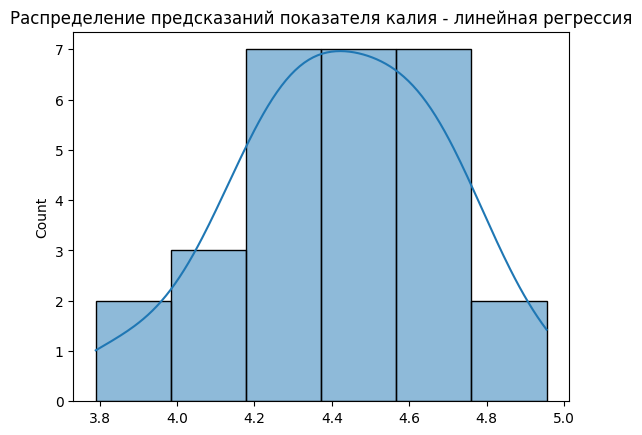

In [15]:
sns.histplot(y_pred, kde=True)
plt.title('Распределение предсказаний показателя калия - линейная регрессия')
None

Для проверки нашей модели используем базовую регрессию, которая обучаетм медианное значение по набору данных, так как во многих признаках распределение далеко от нормального.

Смотрим на функцию потерь

In [17]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)

RMSE_dummy = round(mean_squared_error(y_test, y_pred_dummy, squared=False), 3)

print(f'Dummy RMSE = {RMSE_dummy}')

Dummy RMSE = 0.352


Получилось, что функция потерь оказалась больше, чем функция потерь модели линейной регрессии

Посмотрим на предсказания базовой модели

In [18]:
y_pred_dummy

array([4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45,
       4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45, 4.45,
       4.45, 4.45, 4.45, 4.45, 4.45, 4.45])

Сравним функции потерь у базовой регрессии и линейной регрессии в виде разности первого и второго

In [19]:
round(RMSE_dummy - RMSE, 3)

0.063

## Улучшение модели

Для реализации улучшения модели был использован метод кросс-валидации с выбором модели, имеющую лучшую метрику на фолде. Оптимальное количество n_splits=6 было подобрано экспериментальным путем сравнения качества метрики на разных значениях n_splits

Обучаем модель

In [20]:
from sklearn.model_selection import KFold


kfold = KFold(n_splits=6)

best_rmse = np.inf  # Максимально возможное значение
best_fold = None

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Если новая метрика меньше лучшей
    if rmse < best_rmse:
        best_rmse = rmse
        best_fold = (X_train, X_test, y_train, y_test)

Выбираем модель с лучшей метрикой на фолде и обучаем ее на нашей выборке. Смотрим на функцию потерь

In [21]:
# Берем данные из лучшего фолда
best_X_train, best_X_test, best_y_train, best_y_test = best_fold

best_model = LinearRegression()
best_model.fit(best_X_train, best_y_train)

y_pred = best_model.predict(X_test)

RMSE_best = round(mean_squared_error(y_test, y_pred, squared=False), 3)

print(f'RMSE = {RMSE_best}')

RMSE = 0.256


Смотрим на распределение предсказаний

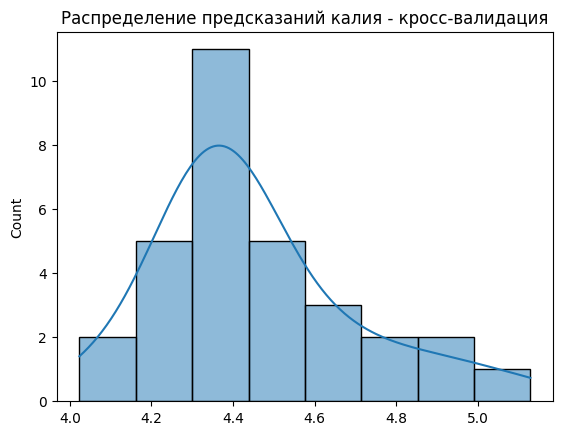

In [22]:
sns.histplot(y_pred, kde=True)
plt.title('Распределение предсказаний калия - кросс-валидация')
None

Описательные статистики предсказаний

In [23]:
pd.Series(y_pred).describe()

count    31.000000
mean      4.451506
std       0.246183
min       4.023627
25%       4.305219
50%       4.383084
75%       4.529453
max       5.128112
dtype: float64

In [26]:
np.median(y_pred)

4.38308368273973

Сравниваем функции потерь

Базовая регрессия (dummy regression)

In [24]:
round(RMSE_dummy - RMSE_best, 3)

0.096

Линейная регрессия (linear regression)

In [ ]:
round(RMSE - RMSE_best, 3)

0.179

## Вывод

В результате анализа стало очевидным, что линейная регрессия предсказывает данные более точно и ближе к реальным значениям. Это подтверждается разницей в функциях потерь: у линейной регрессии значение на 0.06 меньше, чем у базовой модели, что свидетельствует о превосходстве линейной регрессии как более эффективной модели для данного набора данных.

Кроме того, стоит отметить, что модель линейной регрессии, обученная с использованием кросс-валидации, продемонстрировала значительно лучшие результаты по сравнению с остальными моделями. Итоговая метрика составила 0.256, что указывает на способность модели улавливать более сложные зависимости в данных по сравнению с простой линейной регрессией.